# Merging Census 2021 and 2011 Data
Part of [london-data](https://github.com/jamesdamillington/london-data), by [jamesdamillington](https://github.com/jamesdamillington)

## Overview 

This notebook contains code to create a dataset of UK census data for London to enable consistent comparison and analysis between 2011 and 2021 (as some LSOA and MSOA boundaries have change; borough boundaries remain unchanged). 

We utilise the ['exact fit lookup' file](https://hub.arcgis.com/datasets/ons::lsoa-2011-to-lsoa-2021-to-local-authority-district-2022-lookup-for-england-and-wales-version-2/about) between LSOAs. This lookup table has a _'change indicator'_ field that indicates which super output areas have changed between 2011 and 2021 (and how):
- **U**: _No Change from 2011 to 2021._ This means that direct comparisons can be made between these 2011 and 2021 LSOA.
- **S**: _Split._ This means that the 2011 LSOA has been split into two or more 2021 LSOA. There will be one record for each of the 2021 LSOA that the 2011 LSOA has been split into. This means direct comparisons can be made between estimates for the single 2011 LSOA and the estimates from the aggregated 2021 LSOA.
- **M**: _Merged._ 2011 LSOA have been merged with another one or more 2011 LSOA to form a single 2021 LSOA. This means direct comparisons can be made between the aggregated 2011 LSOAs’ estimates and the single 2021 LSOA’s estimates. 
- **X**: _The relationship between 2011 and 2021 LSOA is irregular and fragmented._ This has occurred where 2011 LSOA have been redesigned because of local authority district boundary changes, or to improve their social homogeneity. These can’t be easily mapped to equivalent 2021 LSOA like the regular splits (S) and merges (M), and therefore like for like comparisons of estimates for 2011 LSOA and 2021 LSOA are not possible.

Let's have a look at the data for London to see what we'll need to do.

### Required Libraries
The notebook assumes either the `sds2023` or `london-data` virtual environment has been activated

In [1]:
from datetime import date
print(f'Last tested: {date.today()}')

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from pathlib import Path

Last tested: 2023-10-21


First, read the change indicator data:

In [ ]:
census_igpath = Path("../data/inputs/geographies/census/")
efit = pd.read_csv(census_igpath / "Lookup-ExactFit-LSOA11_to_LSOA21_to_LAD22_EW_Version_2.csv",
                      usecols = list(range(7)))

Next, the shapefile for London LSOAs with 2021 geography:

In [ ]:
census_gpath = Path("../data/geographies/census/")
geometry = gpd.read_file(census_gpath / "london-2021-lsoa-gen20.shp")

And merge them:

In [ ]:
dat_efit = pd.merge(geometry, efit, how='left', on='LSOA21CD')

Now let's see how many of the four different types of change we have in our data:

In [49]:
dat_efit['CHGIND'].value_counts()

CHGIND
U    4659
S     313
M      44
Name: count, dtype: int64

We have majority of unchanged LSOAS (4659). 

We have a few (44) merged LSOAs which can be accounted for easily: assuming the variable is a count we simply sum the values for the multiple 2011 LSOAs and apply to the new 2021 LSOA. 

We have more LSOAs that have been split into two or more 2021 LSOAs (313). These are not so straight-forward and we need to make assumptions about the distribution of people/households across space. If we assume that populations are evenly distributed across space, we can use the areal proportion of the 2011 LSOA that the new (multiple) 2021 LSOAs contributed and scale 2011 data values by those proportions.  

Finally, we are lucky that there are no LSOAs with complex changes in London.

Before we start wrangling, let's do a plot just to quickly see where the different types are (this doesn't matter much for what we will do below, but it might be interesting to see) 

/home/james/anaconda3/envs/sds2023/lib/python3.9/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


<Axes: >

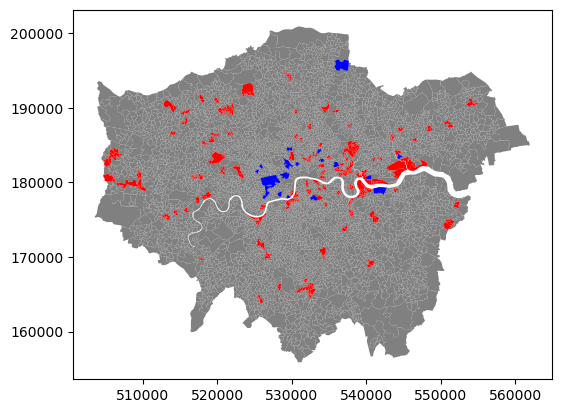

In [52]:
dat_efit['CHGINDint']=dat_efit['CHGIND'].replace(
    to_replace=['U', 'S', 'M'],
    value=[1,2,3])
qcolors = {1:'gray', 2:'red', 3:'blue'}  
dat_efit.plot(column='CHGINDint', cmap=colors.ListedColormap(qcolors.values()))

The next part of the notebook 'Create Dataset' provides code to merge multiple variables from 2011 and 2021 census into a single data file. 

Subsequent to this, the 'Proof-of-concept' part of the notebook works through the required steps using just a single variable (this was actually written first, before the final code in 'Create Dataset'). This second part also creates the `"Lookup-ExactFit-LSOA11_to_LSOA21_to_LAD22_EW_Version_2-London.csv"` file used in the first part of the notebook to subset data to London only (from England and Wales).  

## Create Dataset

When executed the code should read, manipulate, and write a final dataset containing Uk Census data for both 2021 and 2011, with a consistent (2021) data deography. The code reads a metadata file which specifies what variables to include (and the corresponding datafiles for those variables. 

The general structure of the code is as follows:
1. import the required libaries
2. define a function to read and manipulate data for each variable
3. set data paths and read ancillary data
4. read and Manipulate census data
5. write data to file

The function defined in step 2 and the code in step 4 do the majority of the heavy-lifting. See comments in the code for further details. 

In [1]:
#1. import the required libaries
print("Progress:")
print("1. import packages")
import pyproj
import geopandas as gpd
import shapely
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

print("2. define function")
#2. define a function to read and manipulate data for each variable
def read_cdata(dpath, idf, yr):

    #in the two-row df, first row is 2021, second is 2011
    i = 0
    gc = 'geography code'
    if(yr == 2011):
        i = 1
        gc = 'GeographyCode'
    
    #print progress
    print(idf['Series'].iloc[i])  
    
    dat = pd.read_csv(dpath / idf['DataFile'].iloc[i])  #get DataFile name and read 

    #the custom age data for 2021 are in a different format to all other data, so deal with them first
    if(idf['Series'].iloc[i] == 'AgeChild21' or idf['Series'].iloc[i] == 'AgeAdult21' or idf['Series'].iloc[i] == 'AgeSenior21'):
        
        #create lists of the age category codes to filter on below
        childCodes = list(range(1, 7))
        adultCodes = list(range(7, 18))
        seniorCodes = list(range(18,24))
        
        #filter data for this age category
        if(idf['Series'].iloc[i] == 'AgeChild21'):
            dat = dat[dat['Age (23 categories) Code'].isin(childCodes)]
        
        if(idf['Series'].iloc[i] == 'AgeAdult21'):
            dat = dat[dat['Age (23 categories) Code'].isin(adultCodes)]
        
        if(idf['Series'].iloc[i] == 'AgeSenior21'):
            dat = dat[dat['Age (23 categories) Code'].isin(seniorCodes)]
        
        #sum age groups by LSOA (into one of our three age categories) 
        dat = dat.groupby('Lower layer Super Output Areas Code')['Observation'].sum().reset_index()
        
        #rename columns for merging into final data table later
        dat = dat.rename(columns={'Lower layer Super Output Areas Code':'LSOA21CD'})
        dat = dat.rename(columns={'Observation':idf['Series'].iloc[i]})
        
        return(dat)    
    
    #now handle all non-Age21 data
    else:
        #if there are multiple variables, split them on comma
        vids = idf['Variable_ids'].iloc[i].split(",")   #this breaks for 2021 Asian and Black variables because of comma (work-around below)
        vids = [x.strip(' ') for x in vids]    #remove spaces at the beginning and at the end of the string

        #annoyingly there are commas in column names for some variables, work-around here: 
        if(idf['Series'].iloc[i] == 'Asian21'):
            vids = ["Ethnic group: Asian, Asian British or Asian Welsh"]
        if(idf['Series'].iloc[i] == 'Black21'):
            vids = ["Ethnic group: Black, Black British, Black Welsh, Caribbean or African"]
        if(idf['Series'].iloc[i] == 'SocC121'):
            vids = ["C1 Supervisory, clerical and junior managerial/administrative/professional occupations"]

        vids.insert(0, gc)  #add LSOA code column to the list of columns we want to retain
        #ts11 = ts11[[c for c in ts11.columns if c in vids]]  #safer than ts[vids] if column missing
        dat = dat[vids]  #drop unwanted variables (columns) from the data

        dat = dat.set_index(gc)  #set index here 
 
        #2011 data may have multiple columns, these need to be summed 
        if dat.shape[i] > 1:
            dat[idf['Series'].iloc[i]] = dat.sum(axis=1)  #sum (renaming column)
            dat = dat.loc[:, [idf['Series'].iloc[i]]]   #return as a df, not Series
        #when only a single column, no need to sum (just rename column)    
        else:
            dat = dat.rename(columns={vids[i]:idf['Series'].iloc[i]})

        #reset the index (back to a regular column) as we need this for merging later
        dat = dat.reset_index()  
        if(yr == 2011):
            dat = dat.rename(columns={'GeographyCode':'LSOA11CD'})
        else:
            dat = dat.rename(columns={'geography code':'LSOA21CD'})

        return(dat)

print("3. read ancillary data")
#3. Set data paths and read ancillary data
#set input and output paths
census_igpath = Path("../data/inputs/geographies/census/")
census_icpath = Path("../data/inputs/census/")
census_opath = Path("../data/census/")
census_gpath = Path("../data/geographies/census/")

#geometry, area data come from shapefiles 
boundaries = gpd.read_file(census_gpath / "london-2021-lsoa.shp").set_index('LSOA21NM')
geometry = gpd.read_file(census_gpath / "london-2021-lsoa-gen20.shp")

#read meta file
metad = pd.read_csv(census_icpath / "UKCensus-2021-2011-London-metadata.csv",
                    usecols=['Series', 'Variable_ids', 'Year', 'DataFile'])
finalcolumns = metad['Series']  #save for later to re-order output variables (metad will be changed before that)

#read the file detailing 2011-2021 LSOA matches
dat_efit = pd.read_csv(census_igpath / "Lookup-ExactFit-LSOA11_to_LSOA21_to_LAD22_EW_Version_2-London.csv")

    
#4. Read and Manipulate census data
print("4a. loop over variables:")
#4a. 'double loop' over the metadata file (two rows at a time - 2011 and 2021 for each variable) applying the function defined above
#this manipulates the raw census data (e.g. aggregating sub-variables) and does not address 2011vs2021 MAUP issue 
metad.dropna(inplace=True)  #if there are any rows in the metadata with missing values, ignore these variables
metad = metad[~metad.Series.str.endswith('_m21')]   #drop rows for _m21 as we will calculate values for these later
metad = metad.reset_index(drop=True)  #needed for 'double loop' below

#loop
for i, g in metad.groupby(metad.index // 2):
    
    #use function above to read the data in a format we can then use to merge
    dat21 = read_cdata(census_icpath, g, 2021)
    dat11 = read_cdata(census_icpath, g, 2011)
    
    #merge original data for 2011 and 2021
    dat_efit = pd.merge(dat_efit, dat11, how='left', on='LSOA11CD')  #need to merge here on LSOA11CD
    dat_efit = pd.merge(dat_efit, dat21, how='left', on='LSOA21CD')  #merge here on LSOA21CD

#4b. Calculate LSOA areas and merge with 2011 and 2021 data
boundaries['LSOA21KM2'] = round(boundaries['geometry'].area / 10**6, 5)  #calculate area of each LSOA
areas = boundaries[['LSOA21CD', 'LSOA21KM2', 'MSOA21CD', 'MSOA21NM']]  #drop unwanted columns
geometry = geometry[['LSOA21CD', 'geometry']]  #drop unwanted columns

#merge in area data    
dat_efit = pd.merge(dat_efit, areas, how='left', on='LSOA21CD')

#4c. Address 2011vs2021 MAUP issue by calculating 2011 values for 2021 LSOA areas
print("4c. MAUP issue")
#calculate proportion of 2021 LSOA that 2011 LSOA composes
dat_efit['LSOAP21'] = round(dat_efit['LSOA21KM2'] / dat_efit.groupby('LSOA11CD')['LSOA21KM2'].transform('sum'),4)

#add change indicator column
dat_efit.loc[dat_efit['CHGIND'] == 'M', 'LSOAP21'] = 2

#now calculate m21 variable values and add to dataframe                      
for i, g in metad.groupby(metad.index // 2):

    newnm = g['Series'].iloc[1] + "_m21"  #name for column to be created
    dat_efit[newnm] = round(dat_efit[g['Series'].iloc[1]] * dat_efit['LSOAP21']) #calc proportional area value for 2021 from 2011 
    #overwrite values for 2021 LSOAs produced by merging 2011 LSOAs 
    dat_efit.loc[dat_efit['CHGIND']=='M',newnm] = dat_efit[dat_efit['CHGIND']=='M'].groupby('LSOA21CD')[g['Series'].iloc[1]].transform('sum')

#merge in gemetry data (using 2021 gemetry)    
dat_efit = pd.merge(dat_efit, geometry, how='left', on='LSOA21CD')

print("5. write data")
#5. Write data to file
#reorder columns for output  (with help from https://stackoverflow.com/a/53299403)
#metad = pd.read_csv(census_icpath / "london-census21-metadata.csv",usecols=['Series'])
existing = [i for i in finalcolumns if i in dat_efit.columns]
dat_efit = dat_efit[existing]

#before writing convert all observations to int
chgcol = dat_efit.loc[:,'TotRes21':].columns.values
dat_efit[chgcol]=dat_efit[chgcol].astype(int)

#print to file
dat_efit.to_csv(census_opath / "UKCensus-21-11-London-21geog-alldata.csv", index=False)
    

Progress:
1. import packages
2. define function
3. read ancillary data
4a. loop over variables:
TotRes21
TotRes11
TotHHolds21
TotHHolds11
FemRes21
FemRes11
MalRes21
MalRes11
Asian21
Asian11
Black21
Black11
MixedE21
MixedE11
White21
White11
OtherE21
OtherE11
CarsZero21
CarsZero11
CarsOne21
CarsOne11
CarsTwo21
CarsTwo11
CarsThrp21
CarsThrp11
EconEm21
EconEm11
EconUn21
EconUn11
EconSt21
EconSt11
EconRe21
EconRe11
EconOt21
EconOt11
AgeChild21
AgeChild11
AgeAdult21
AgeAdult11
AgeSenior21
AgeSenior11
HealthVG21
HealthVG11
HealthGood21
HealthGood11
HealthFair21
HealthFair11
HealthBad21
HealthBad11
HealthVB21
HealthVB11
QualNone21
QualNone11
QualSch21
QualSch11
QualUni21
QualUni11
QualOt21
QualOt11
4c. MAUP issue
5. write data


Subset to only rows and columns for 2021 geography

In [2]:
df21 = dat_efit.drop_duplicates('LSOA21NM')  #duplicates will be for 2011 geography
df21 = df21.loc[:, ~df21.columns.str.endswith('11')]  #drop 2011 original data
df21 = df21.drop(columns=['LSOA11CD','LSOA11NM'])  #drop 2011 LSOA names and manipulator columns 
df21 = df21.reset_index(drop=True)  
df21.head()

#print to file
df21.to_csv(census_opath / "UKCensus-21-11-London-21geog-data.csv", index=False)

Add code here to create 2011 geography dataset (with 2011 data only)

## Proof of Concept

### Overview

1. Read Data
    - Read exact fit lookup
        - subset to London Boroughs
    - Read 2011 data (e.g. KS101EWDATA06.CSV from [here](https://www.nomisweb.co.uk/census/2011/bulk/r2_2))
    - Read 2021 data (e.g. census2021-ts001-lsoa.csv from [here](https://www.nomisweb.co.uk/census/2021/bulk))
    - Read 2021 geometries (london-2021-lsoa.shp created [here](https://github.com/jamesdamillington/london-data/blob/main/code/london-census2021-geography.ipynb))
    - calculate polygon area
2. Merge Data
    - Merge 2011 data to bestfit on LSOA11CD 
    - Merge 2021 data to bestfit on LSOA21CD
    - Merge 2021 areas on LSOA21CD
3. Calculate Areal Proportions
    - Create '2021 area prop' column:
        - Where CHGIND is U, set value 1
        - Where CHGIND is M, set value 2
        - Where CHGIND is S: calculate proportion from sum of areas for LSOAs with identical LSOA11CD 
4. Set Values
    - Create 'merged 2011' column
        - Where CHGIND is U, use original 2011 data value 
        - Where CHGIND is M, use sum of 2011 LSOAs with the LSOA21CD for M
        - Where CHGIND is S, multiply original 2011 data value by '2021 area prop'

In [2]:
import pyproj
import geopandas as gpd
import shapely
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

### Read Data

Read exact fit lookup spreadsheet then subset to London Boroughs

In [3]:
census_igpath = Path("../data/inputs/geographies/census/")
efit = pd.read_csv(census_igpath / "Lookup-ExactFit-LSOA11_to_LSOA21_to_LAD22_EW_Version_2.csv",
                      usecols = list(range(7)))

In [4]:
efit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35796 entries, 0 to 35795
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   LSOA11CD  35796 non-null  object
 1   LSOA11NM  35796 non-null  object
 2   LSOA21CD  35796 non-null  object
 3   LSOA21NM  35796 non-null  object
 4   CHGIND    35796 non-null  object
 5   LAD22CD   35796 non-null  object
 6   LAD22NM   35796 non-null  object
dtypes: object(7)
memory usage: 1.9+ MB


In [5]:
lads = pd.unique(efit.LAD22NM)
lads

array(['City of London', 'Barking and Dagenham', 'Bexley', 'Barnet',
       'Brent', 'Bromley', 'Croydon', 'Camden', 'Ealing', 'Enfield',
       'Greenwich', 'Hackney', 'Haringey', 'Hammersmith and Fulham',
       'Hillingdon', 'Harrow', 'Havering', 'Islington', 'Hounslow',
       'Kensington and Chelsea', 'Kingston upon Thames', 'Lambeth',
       'Lewisham', 'Merton', 'Redbridge', 'Newham', 'Sutton', 'Southwark',
       'Richmond upon Thames', 'Tower Hamlets', 'Waltham Forest',
       'Wandsworth', 'Bury', 'Bolton', 'Westminster', 'Manchester',
       'Oldham', 'Rochdale', 'Salford', 'Stockport', 'Trafford', 'Wigan',
       'Tameside', 'Knowsley', 'Liverpool', 'Sefton', 'Wirral',
       'St. Helens', 'Doncaster', 'Barnsley', 'Rotherham', 'Sheffield',
       'Gateshead', 'Newcastle upon Tyne', 'North Tyneside', 'Sunderland',
       'South Tyneside', 'Birmingham', 'Coventry', 'Dudley', 'Sandwell',
       'Solihull', 'Walsall', 'Wolverhampton', 'Bradford', 'Calderdale',
       'Leeds', '

From this we can see London boroughs _are_ listed first (except for Westminster - Bury and Bolton will need to be dropped), so we can get list of borough names relatively easily:

In [6]:
lads = list(lads)
london_lads = lads[:lads.index('Westminster')+1]
london_lads.remove("Bury")
london_lads.remove("Bolton")
print(london_lads)
print(len(london_lads))

['City of London', 'Barking and Dagenham', 'Bexley', 'Barnet', 'Brent', 'Bromley', 'Croydon', 'Camden', 'Ealing', 'Enfield', 'Greenwich', 'Hackney', 'Haringey', 'Hammersmith and Fulham', 'Hillingdon', 'Harrow', 'Havering', 'Islington', 'Hounslow', 'Kensington and Chelsea', 'Kingston upon Thames', 'Lambeth', 'Lewisham', 'Merton', 'Redbridge', 'Newham', 'Sutton', 'Southwark', 'Richmond upon Thames', 'Tower Hamlets', 'Waltham Forest', 'Wandsworth', 'Westminster']
33


Now subset using this list of 33 boroughs

In [7]:
efit = efit[efit['LSOA21NM'].str.contains("|".join(london_lads))]   #from https://stackoverflow.com/a/71399966
efit = efit.copy(deep=False)
efit.head()

,LSOA11CD,LSOA11NM,LSOA21CD,LSOA21NM,CHGIND,LAD22CD,LAD22NM
0,E01000001,City of London 001A,E01000001,City of London 001A,U,E09000001,City of London
1,E01000002,City of London 001B,E01000002,City of London 001B,U,E09000001,City of London
2,E01000003,City of London 001C,E01000003,City of London 001C,U,E09000001,City of London
3,E01000005,City of London 001E,E01000005,City of London 001E,U,E09000001,City of London
4,E01000006,Barking and Dagenham 016A,E01000006,Barking and Dagenham 016A,U,E09000002,Barking and Dagenham


In [8]:
pd.unique(efit.LAD22NM)

array(['City of London', 'Barking and Dagenham', 'Bexley', 'Barnet',
       'Brent', 'Bromley', 'Croydon', 'Camden', 'Ealing', 'Enfield',
       'Greenwich', 'Hackney', 'Haringey', 'Hammersmith and Fulham',
       'Hillingdon', 'Harrow', 'Havering', 'Islington', 'Hounslow',
       'Kensington and Chelsea', 'Kingston upon Thames', 'Lambeth',
       'Lewisham', 'Merton', 'Redbridge', 'Newham', 'Sutton', 'Southwark',
       'Richmond upon Thames', 'Tower Hamlets', 'Waltham Forest',
       'Wandsworth', 'Westminster', 'Brentwood'], dtype=object)

We end up including Brentwood (not a London borough) so need to remove this

In [9]:
efit = efit[~efit['LSOA21NM'].str.contains('Brentwood')]

In [10]:
pd.unique(efit.LAD22NM)

array(['City of London', 'Barking and Dagenham', 'Bexley', 'Barnet',
       'Brent', 'Bromley', 'Croydon', 'Camden', 'Ealing', 'Enfield',
       'Greenwich', 'Hackney', 'Haringey', 'Hammersmith and Fulham',
       'Hillingdon', 'Harrow', 'Havering', 'Islington', 'Hounslow',
       'Kensington and Chelsea', 'Kingston upon Thames', 'Lambeth',
       'Lewisham', 'Merton', 'Redbridge', 'Newham', 'Sutton', 'Southwark',
       'Richmond upon Thames', 'Tower Hamlets', 'Waltham Forest',
       'Wandsworth', 'Westminster'], dtype=object)

This list of unique boroughs in our bestfit table now looks right.

In [11]:
efit.to_csv(census_igpath / "Lookup-ExactFit-LSOA11_to_LSOA21_to_LAD22_EW_Version_2-London.csv", 
            index=False)

Next, read 2011 data 

In [12]:
census_icpath = Path("../data/inputs/census/")

In [13]:
ts11 = pd.read_csv(census_icpath / "KS101EWDATA06.CSV")

In [14]:
ts11.head()

,GeographyCode,KS101EW0001,KS101EW0002,KS101EW0003,KS101EW0004,KS101EW0005,KS101EW0006,KS101EW0007,KS101EW0008,KS101EW0009,KS101EW0010,KS101EW0011,KS101EW0012
0,E01000001,1465,767,698,1465,0,21,12.98,112.865948,52.354949,47.645051,100.000000,0.000000
1,E01000002,1436,767,669,1436,0,22,22.84,62.872154,53.412256,46.587744,100.000000,0.000000
2,E01000003,1346,714,632,1250,96,12,5.91,227.749577,53.046062,46.953938,92.867756,7.132244
3,E01000005,985,528,457,985,0,5,18.96,51.951477,53.604061,46.395939,100.000000,0.000000
4,E01000006,1703,866,837,1699,4,16,14.66,116.166439,50.851439,49.148561,99.765120,0.234880


In [15]:
ts11 = ts11[['GeographyCode', 'KS101EW0001']]
ts11 = ts11.set_axis(['LSOA11CD', 'TotalRes11'], axis=1)

In [16]:
ts11.head()

,LSOA11CD,TotalRes11
0,E01000001,1465
1,E01000002,1436
2,E01000003,1346
3,E01000005,985
4,E01000006,1703


Read 2021 data

In [17]:
ts21 = pd.read_csv(census_icpath / "census2021-ts001-lsoa.csv")

In [18]:
ts21.head()

,date,geography,geography code,Residence type: Total; measures: Value,Residence type: Lives in a household; measures: Value,Residence type: Lives in a communal establishment; measures: Value
0,2021,Hartlepool 001A,E01011954,2284,2284,0
1,2021,Hartlepool 001B,E01011969,1344,1344,0
2,2021,Hartlepool 001C,E01011970,1070,1070,0
3,2021,Hartlepool 001D,E01011971,1323,1323,0
4,2021,Hartlepool 001F,E01033465,1955,1955,0


In [19]:
ts21 = ts21[['geography code', 'Residence type: Total; measures: Value']]
ts21 = ts21.set_axis(['LSOA21CD', 'TotalRes21'], axis=1)

In [20]:
ts21.head()

,LSOA21CD,TotalRes21
0,E01011954,2284
1,E01011969,1344
2,E01011970,1070
3,E01011971,1323
4,E01033465,1955


Read 2021 geometries then calculate polygon area

In [21]:
census_gpath = Path("../data/geographies/census/")
boundaries = gpd.read_file(census_gpath / "london-2021-lsoa.shp").set_index('LSOA21NM')

In [22]:
print(boundaries.crs)

EPSG:27700


In [23]:
boundaries['sqkm21'] = round(boundaries['geometry'].area / 10**6, 5)

In [24]:
boundaries.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 4994 entries, City of London 001A to Westminster 024G
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   LSOA21CD  4994 non-null   object  
 1   MSOA21CD  4994 non-null   object  
 2   MSOA21NM  4994 non-null   object  
 3   LAD22CD   4994 non-null   object  
 4   LAD22NM   4994 non-null   object  
 5   geometry  4994 non-null   geometry
 6   sqkm21    4994 non-null   float64 
dtypes: float64(1), geometry(1), object(5)
memory usage: 441.2+ KB


In [25]:
areas = boundaries[['LSOA21CD', 'sqkm21']]

Note that we have dropped the geometry column here. The full resolution (highest precision) geometry data produces a large (~90MB) file so we drop here and will merge simplified geometry (_london-2021-lsoa-gen20.csv_ from `london-census2021-geography.ipynb`) later.

### Merge Data
- Merge 2011 data to bestfit on LSOA11CD 
- Merge 2021 data to bestfit on LSOA21CD
- Merge 2021 areas on LSOA21CD

In [26]:
merge_efit = pd.merge(efit, ts11, how='left', on='LSOA11CD')

In [27]:
merge_efit = pd.merge(merge_efit, ts21, how='left', on='LSOA21CD')

In [28]:
merge_efit = pd.merge(merge_efit, areas, how='left', on='LSOA21CD')

In [29]:
merge_efit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5016 entries, 0 to 5015
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   LSOA11CD    5016 non-null   object 
 1   LSOA11NM    5016 non-null   object 
 2   LSOA21CD    5016 non-null   object 
 3   LSOA21NM    5016 non-null   object 
 4   CHGIND      5016 non-null   object 
 5   LAD22CD     5016 non-null   object 
 6   LAD22NM     5016 non-null   object 
 7   TotalRes11  5016 non-null   int64  
 8   TotalRes21  5016 non-null   int64  
 9   sqkm21      5016 non-null   float64
dtypes: float64(1), int64(2), object(7)
memory usage: 392.0+ KB


### Calculate Proportions
- Create '2021 area prop' column:
    - Where CHGIND is U, set value 1
    - Where CHGIND is M, set value 2
    - Where CHGIND is S: calculate proportion from sum of areas for LSOAs with identical LSOA11CD 

For U and S, groupby 2011 LSOA code and calculate the proportion (this will be 1 for unsplit LSOAs) 

In [30]:
merge_efit['prop21'] = round(merge_efit['sqkm21'] / merge_efit.groupby('LSOA11CD')['sqkm21'].transform('sum'),4)
#from https://stackoverflow.com/a/57359372

In [31]:
merge_efit.loc[merge_efit['CHGIND'] == 'M', 'prop21'] = 2

### Set Values
- Create 'merged 2011' column
    - Where CHGIND is U, use original 2011 data value 
    - Where CHGIND is M, use sum of 2011 LSOAs with the LSOA21CD for M
    - Where CHGIND is S, multiply original 2011 data value by '2021 area prop'

In [32]:
merge_efit['TotalRes11m21'] = round(merge_efit['TotalRes11o'] * merge_efit['prop21'])
merge_efit['TotalRes11m21'] = merge_efit['TotalRes11m21'].astype(int)

In [33]:
merge_efit.loc[merge_efit['CHGIND']=='M','TotalRes11m21'] = merge_efit[merge_efit['CHGIND']=='M'].groupby('LSOA21CD')['TotalRes11'].transform('sum')

C:\Users\james\AppData\Local\Temp\ipykernel_14676\1808171169.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[2709 2709 3159 3159 3131 3131 2583 2583 3088 3088 2116 2116 3400 3400
 4267 4267 3042 3042 3252 3252 3026 3420 3420 2410 2640 2969 2410 2969
 2267 2267 3123 3123 2451 2451 2699 2699 2457 2457 3026 2562 2562 2559
 2559 2640]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  merge_efit.loc[merge_efit['CHGIND']=='M','TotalRes11_21c'] = merge_efit[merge_efit['CHGIND']=='M'].groupby('LSOA21CD')['TotalRes11'].transform('sum')


In [34]:
merge_efit[merge_efit['CHGIND']=='S'].head()

,LSOA11CD,LSOA11NM,LSOA21CD,LSOA21NM,CHGIND,LAD22CD,LAD22NM,TotalRes11,TotalRes21,sqkm21,prop21,TotalRes11_21c
4606,E01003109,Lambeth 003E,E01033863,Lambeth 003G,S,E09000022,Lambeth,2255,1325,0.10111,0.3758,847
4607,E01033207,Lambeth 004F,E01033864,Lambeth 004H,S,E09000022,Lambeth,1708,1032,0.06158,0.2551,436
4608,E01033207,Lambeth 004F,E01033865,Lambeth 004I,S,E09000022,Lambeth,1708,1520,0.13870,0.5745,981
4609,E01033207,Lambeth 004F,E01033866,Lambeth 004J,S,E09000022,Lambeth,1708,1120,0.04116,0.1705,291
4610,E01003927,Southwark 002A,E01033867,Southwark 002F,S,E09000028,Southwark,2377,1547,0.16428,0.5815,1382


In [35]:
#with help from https://stackoverflow.com/a/68453949
cols = ['sqkm21','prop21','TotalRes21','TotalRes11o','TotalRes11m21']
merge_efit = merge_efit[[c for c in merge_efit.columns if c not in cols]+ cols]

In [36]:
merge_efit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5016 entries, 0 to 5015
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   LSOA11CD        5016 non-null   object 
 1   LSOA11NM        5016 non-null   object 
 2   LSOA21CD        5016 non-null   object 
 3   LSOA21NM        5016 non-null   object 
 4   CHGIND          5016 non-null   object 
 5   LAD22CD         5016 non-null   object 
 6   LAD22NM         5016 non-null   object 
 7   sqkm21          5016 non-null   float64
 8   prop21          5016 non-null   float64
 9   TotalRes21      5016 non-null   int64  
 10  TotalRes11      5016 non-null   int64  
 11  TotalRes11_21c  5016 non-null   int64  
dtypes: float64(2), int64(3), object(7)
memory usage: 470.4+ KB


In [37]:
census_opath = Path("../data/census/")
merge_efit.to_csv(census_opath / "merge_efit.csv", index=False)

MIT License. Copyright (c) 2023 James Millington